In [2]:
from dotenv import load_dotenv
load_dotenv("../chatbot/.env")

True

In [3]:
import os
os.environ["LANGCHAIN_PROJECT"] = "llama3.2-parallel-execution"

In [4]:
from langchain_ollama import ChatOllama
model = ChatOllama(model="llama3.2", temperature=0)

In [5]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

class State(TypedDict):
    question : str
    answer: str 
    context: Annotated[list, operator.add]

In [27]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

In [33]:
def tavily_search(state):
    tavily_search = TavilySearchResults(max_results=2)
    search_docs = tavily_search.invoke(state["question"])
    return {"context": [doc["content"] for doc in search_docs]}
    

In [31]:
from langchain_community.tools import TavilySearchResults

In [47]:
TavilySearchResults(max_results=3).invoke("How were Nvidia's Q2 2024 earnings")

[{'url': 'https://www.axios.com/2024/08/28/nvidia-stock-earnings-call-q2-report',
  'content': 'Analysts polled by FactSet were expecting $28.72 billion in revenue and earnings of $0.65 a share. ... For context, in Q2 2024, there were 144'},
 {'url': 'https://www.cnbc.com/2024/08/28/nvidia-nvda-earnings-report-q2-2025.html',
  'content': 'Best Credit Cards Best Loans to Refinance Credit Card Debt Best Credit Cards for Small Business Best Small Business Loans Best Personal Loans for Bad Credit Nvidia said it expects about $32.5 billion in current-quarter revenue, versus $31.7 billion expected by analysts, according to StreetAccount. Revenue in Nvidia\'s data center business, which includes its AI processors, climbed 154% from a year earlier to $26.3 billion, accounting for 88% of total sales. Nvidia said it shipped samples of Blackwell chips during the quarter, and made a change to the product to make it more efficient to manufacture. "In the fourth quarter, we expect to ship several bi

In [49]:
tavily_search({"question":"How were the Nvida's q1 2024 earnings"})

{'context': ['NVIDIA Q1 2024 Earnings: AI Demand Fuels Growth Leading to Stock Split NVIDIA Q1 2024 Earnings: AI Demand Fuels Growth Leading to Stock Split Stay up to date on the latest stock and economic news that may affect NVIDIA and the rest of your portfolio. Get the latest market news delivered right to your inbox, including news that affects NVIDIA. Following the earnings report, NVIDIA’s stock price crossed the $1,000 threshold for the first time in after-hours trading, rising from a $949.50 close before the call on May 22, 2024. NVIDIA announced a 10-for-1 stock split on the Q1 earnings call. The post NVIDIA Q1 2024 Earnings: AI Demand Fuels Growth Leading to Stock Split appeared first on SmartReads by SmartAsset.',
  'Certain statements in this press release including, but not limited to, statements as to: the computer industry going through two simultaneous transitions – accelerated computing and generative AI; installed global data center infrastructure transitioning from g

In [13]:
def search_wikipedia(state):
    search_docs = WikipediaLoader(query=state["question"],
                                  load_max_docs=2).load()
    return {"context": [doc.page_content for doc in search_docs]}

In [50]:
search_wikipedia({"question":"How were the Nvida's q1 2024 earnings"})

{'context': []}

In [41]:
def model_ans(state):
    context = state["context"]
    question = state["question"]
    
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    answer = model.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
    return {"answer": answer}

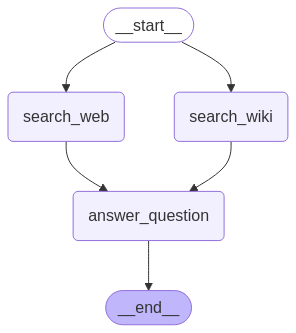

In [42]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END

graph = StateGraph(State)

graph.add_node("search_web", tavily_search)
graph.add_node("search_wiki", search_wikipedia)
graph.add_node("answer_question", model_ans)

graph.add_edge(START, "search_web")
graph.add_edge(START, "search_wiki")
graph.add_edge("search_web", "answer_question")
graph.add_edge("search_wiki", "answer_question")
graph.add_edge("answer_question", END)

agent = graph.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [46]:
result = agent.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"Unfortunately, the provided text does not mention Nvidia's Q2 2024 earnings. However, I can provide some context and information about Nvidia's recent financial performance.\n\nAccording to a report by StreetAccount, Nvidia expects $32.5 billion in revenue for its current quarter, which is higher than the expected $28.72 billion by analysts polled by FactSet. In terms of earnings, Nvidia expects around $0.65 per share, which is slightly above the expected $0.65 per share by analysts.\n\nIt's worth noting that Nvidia has been performing well in recent quarters, driven by strong demand for its graphics processing units (GPUs) and other products. The company's data center business, which includes its AI computing and high-performance computing offerings, has also been a significant contributor to its revenue growth.\n\nIf you're looking for more information on Nvidia's Q2 2024 earnings, I recommend checking the company's official financial reports or reputable financial news sources such